### 1. 특징 추출을 위해 사전 훈련된 모델 사용하기: 

- 이미 학습된 모델가져오기
- 필요에 따라 수정하고 마지막 층 추가
- 기존 모델 동결 후 학습
- 그래프로 비교

### 2. 사전 훈련된 모델을 미세 조정(finetuning)하기: 
- 기존 모델 일부 또는 전부 동결 해제(100개 층만 동결)
- 학습 (시간↑, 정확도↑)
- 1, 2 그래프로 비교

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import drive 
import zipfile as zf
!pip install split-folders  # 각 라벨마다 train, val 파일 생성 및 데이터 나누기
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
drive.mount('/gdrive') # 구글드라이브 연결 https://www.youtube.com/watch?v=fAgTGrcKE2E

Mounted at /gdrive


In [3]:
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/onlyimagedata.zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [4]:
os.mkdir("/content/data_new")
splitfolders.ratio('/content/data', output="/content/data_new", seed=77, ratio=(0.8, 0.2))#(8대2)

Copying files: 60000 files [00:09, 6254.63 files/s]


In [5]:
train_dir = '/content/data_new/train/'
val_dir = '/content/data_new/val/'

batch_size = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size= IMG_SIZE, 
  batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_dataset.class_names
num_classes = len(class_names)

Found 48000 files belonging to 6 classes.
Found 12000 files belonging to 6 classes.


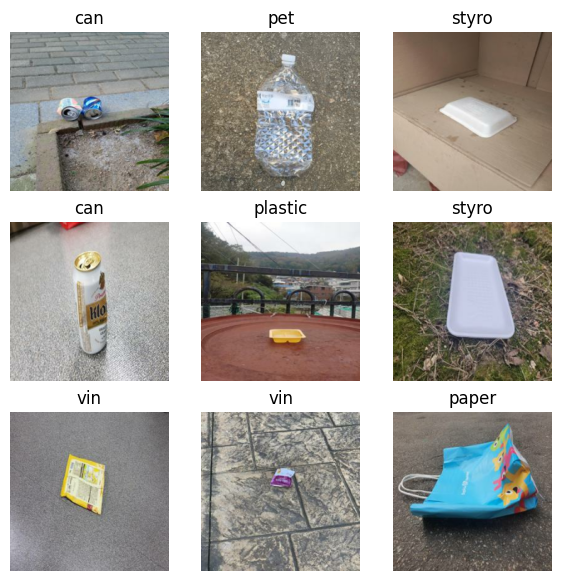

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(7, 7))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE  # buffered prefecthing을 사용해 I/O에 막힘 없이 이미지를 디스크에서 읽어올 수 있도록 한다.

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([ #data augmentation ->  model.fit에만 적용
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input # 모델 다운로드

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # 픽셀 값을 [0, 255]에서 [-1, 1]로 다시 조정

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=False, # 맨 위 분류층 제외
                                               weights='imagenet')
 # 160x160x3 이미지를 (배치사이즈, 5x5x1280)의 특징 블록으로 변환
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

base_model.trainable = False # 주어진 레이어의 가중치가 훈련 중에 업데이트되는 것을 방지 (Trainable params: 0) 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # 아웃풋에 풀링을 적용, 5x5 공간 위치에 대한 평균을 구하기
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape) #(32 , 1280) 

prediction_layer = tf.keras.layers.Dense(num_classes) # 특성을 이미지당 단일 예측으로 변환
prediction_batch = prediction_layer(feature_batch_average) # prediction_batch  = (32 , 1) 
base_model.summary() # 기존 구조 확인

4334752/4334752 [==============================] - 1s 0us/step
(32, 576)
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
          

In [11]:
inputs = tf.keras.Input(shape=(224, 224, 3)) #  데이터 증강, 크기 조정, base_model 및 특성 추출기 레이어를 연결해 하나의 모델 만들기
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# 모델을 훈련시키기 전에 컴파일
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

base_model.summary() # 변경한 구조 확인인

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [12]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

375/375 [==============================] - 25s 50ms/step - loss: 1.9328 - accuracy: 0.2209


In [13]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
1500/1500 [==============================] - 96s 61ms/step - loss: 1.1705 - accuracy: 0.5590 - val_loss: 0.7890 - val_accuracy: 0.7240
Epoch 2/10
1500/1500 [==============================] - 86s 57ms/step - loss: 0.8073 - accuracy: 0.7125 - val_loss: 0.6657 - val_accuracy: 0.7670
Epoch 3/10
1500/1500 [==============================] - 89s 59ms/step - loss: 0.7204 - accuracy: 0.7437 - val_loss: 0.6091 - val_accuracy: 0.7888
Epoch 4/10
1500/1500 [==============================] - 85s 57ms/step - loss: 0.6744 - accuracy: 0.7626 - val_loss: 0.5791 - val_accuracy: 0.7987
Epoch 5/10
1500/1500 [==============================] - 93s 62ms/step - loss: 0.6484 - accuracy: 0.7707 - val_loss: 0.5587 - val_accuracy: 0.8070
Epoch 6/10
1500/1500 [==============================] - 85s 57ms/step - loss: 0.6309 - accuracy: 0.7772 - val_loss: 0.5443 - val_accuracy: 0.8124
Epoch 7/10
1500/1500 [==============================] - 85s 56ms/step - loss: 0.6143 - accuracy: 0.7825 - val_loss: 0.5319 -

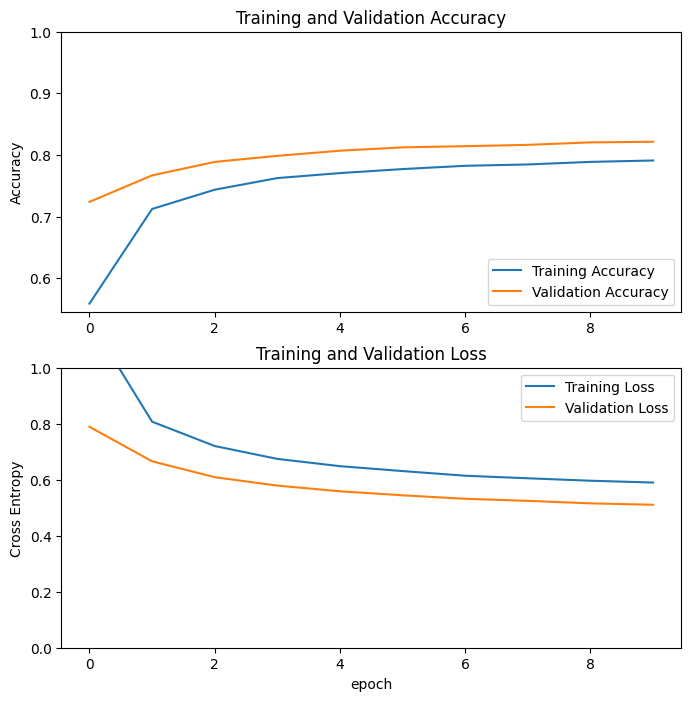

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

미세조정 : 상단 레이어를 함께 fine-tuning하면 모델 퍼포먼스를 향상

In [15]:
base_model.trainable = True


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# 154개의 층
print("Number of layers in the base model: ", len(base_model.layers))

# base_model의 파라미터들을 학습 가능하도록 하고, 밑에서부터 N(=100)개의 레이어만 고정
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# 학습된 weight에 이어서 학습을 진행 -> 과대적합을 막기 위해 낮은 학습률 사용
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

Number of layers in the base model:  229


In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                                 
 dense (Dense)               (None, 6)                 3462

In [18]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
1500/1500 [==============================] - 113s 65ms/step - loss: 0.5242 - accuracy: 0.8139 - val_loss: 0.4296 - val_accuracy: 0.8497
Epoch 11/20
1500/1500 [==============================] - 103s 69ms/step - loss: 0.4635 - accuracy: 0.8359 - val_loss: 0.3957 - val_accuracy: 0.8603
Epoch 12/20
1500/1500 [==============================] - 101s 67ms/step - loss: 0.4273 - accuracy: 0.8482 - val_loss: 0.3688 - val_accuracy: 0.8721
Epoch 13/20
1500/1500 [==============================] - 98s 65ms/step - loss: 0.3990 - accuracy: 0.8595 - val_loss: 0.3565 - val_accuracy: 0.8749
Epoch 14/20
1500/1500 [==============================] - 97s 65ms/step - loss: 0.3782 - accuracy: 0.8653 - val_loss: 0.3427 - val_accuracy: 0.8811
Epoch 15/20
1500/1500 [==============================] - 99s 66ms/step - loss: 0.3627 - accuracy: 0.8722 - val_loss: 0.3292 - val_accuracy: 0.8858
Epoch 16/20
1500/1500 [==============================] - 99s 66ms/step - loss: 0.3439 - accuracy: 0.8771 - val_loss

In [19]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

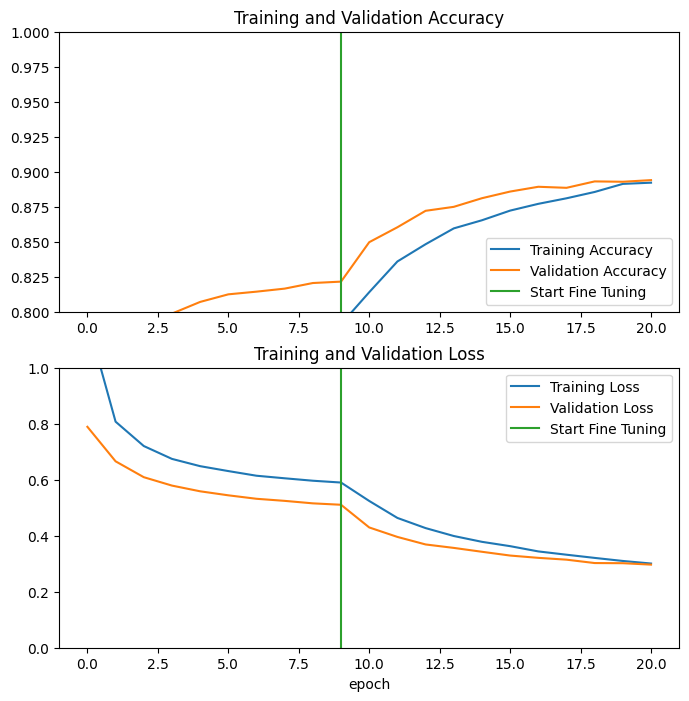

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
model.save('model.h5') # 모델 통채로 저장

In [ ]:
  # 모델 불러오기
  load_model = tf.keras.models.load_model('model.h5')